In [35]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet import *

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
from qvarnet.models.mlp import MLP

model = MLP(layer_dims=[1,2,1])
model.to(device)
print(model)

MLP(input_dim=1, output_dim=1, hidden_dims=[2], activation=tanh)


In [37]:
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator

class TestHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return -torch.exp(-x**2)
    
hamiltonian = TestHamiltonian(model=model)
hamiltonian.to(device)
print(hamiltonian(torch.tensor([2.0], device=device))) # check that the hamiltonian is working

tensor([-0.0183], device='cuda:0')


Sample mean: -0.1030
Sample std: 1.0031


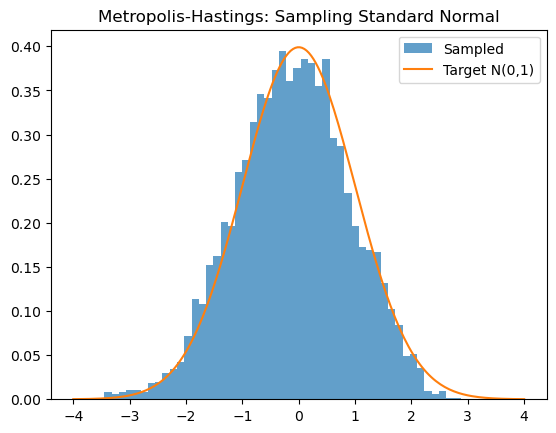

In [38]:
from qvarnet.samplers import MetropolisHastingsSampler

# Simple harmonic oscillator: E(x) = 0.5 * x^2
class HarmonicHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return 0.5 * x.pow(2).sum(dim=-1)

# Your sampler
sampler = MetropolisHastingsSampler(
    model=HarmonicHamiltonian(),
    n_samples=5000,
    step_size=0.5,
    burn_in=500,
    is_wf=False,
)

sampler.to(device)

# Initial point
x0 = torch.tensor([0.0], device=device)

# Run sampler
samples = sampler(x0)
samples_np = samples.cpu().detach().numpy().flatten()

# Statistics
mean = samples_np.mean()
std = samples_np.std()

print(f"Sample mean: {mean:.4f}")
print(f"Sample std: {std:.4f}")

# Histogram
plt.hist(samples_np, bins=50, density=True, alpha=0.7, label='Sampled')
xs = torch.linspace(-4, 4, 200)
plt.plot(xs, torch.exp(-0.5 * xs**2) / (2 * torch.pi)**0.5, label='Target N(0,1)')
plt.legend()
plt.title("Metropolis-Hastings: Sampling Standard Normal")
plt.show()

In [39]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

def V(x):
    return 0.5 * x**2

In [54]:
import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < self.best_energy - self.min_delta:
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

In [59]:
from tqdm import tqdm
epochs = 10000

model = MLP(layer_dims=[1, 60, 1])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

x_train = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
x_train.requires_grad = True

callback = EarlyStoppingCallback(patience=100, min_delta=1e-5)

print_interval = 100

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train) # computes forward pass
    T = kinetic_energy(psi, x_train)
    # V_psi = V(x_train) * psi
    H_psi = T #+ V_psi

    numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
    energy = numerator / denominator
    loss = energy.item()

    # boundary conditions
    loss += 1e-2 * (psi[0]**2+ psi[-1]**2).sum()
    
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy.item():.4f}")

    if callback is not None:
        callback(epoch, energy.item(), model)

        # If the callback indicates stopping, break the training loop
        if hasattr(callback, 'stop_training') and callback.stop_training:
            model.load_state_dict(callback.best_model_state)
            print(f"Training stopped early at epoch {epoch+1}")
            break
    
print(energy)

model parameters:
model.0.weight torch.Size([60, 1])
model.0.bias torch.Size([60])
model.2.weight torch.Size([1, 60])
model.2.bias torch.Size([1])
Epoch 1/10000, Loss: 0.2170, Energy: 0.2140
Epoch 101/10000, Loss: 1.2523, Energy: 1.2523
Stopping training after 101 epochs due to no improvement in energy.
Training stopped early at epoch 101
tensor([1.2523], device='cuda:0', grad_fn=<DivBackward0>)


# Sampler stuff

In [ ]:
from tqdm import tqdm
epochs = 10000

model = MLP(layer_dims=[1, 60, 1])
model.to(device)

hamiltonian = HarmonicOscillator(model=model)

hamiltonian.to(device)

sampler = MetropolisHastingsSampler(
    model=model,
    n_samples=500,
    step_size=0.2,
    burn_in=10,
)

# Initial point
x0 = torch.tensor([0.0], device=device, requires_grad=True)

""".view(-1, 1) is used to ensure that x0 is a column vector.
   This is important for the MLP model, which expects input of shape (batch_size, input_dim).
   In this case, input_dim is 1 (since we are dealing with a single variable).
"""

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

x_train = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
x_train.requires_grad = True

samples = torch.randn(10000, 1).to(device)
samples.requires_grad = True

trapezoid = True

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    # Run sampler
    if not trapezoid:
        x0 = torch.randn(1).to(device)
        samples = sampler(x0)
        samples.requires_grad = True

        # Compute the mean and std of the local energy
        local_energy = hamiltonian(samples)
        psi = model(samples)
        energy = local_energy.mean().item()
        energy_std = local_energy.std().item()
        loss = local_energy.mean()

    if trapezoid:
        psi = model(x_train) # computes forward pass
        T = kinetic_energy(psi, x_train)
        # V_psi = V(x_train) * psi
        H_psi = T #+ V_psi

        numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
        denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
        energy = numerator / denominator
        loss = energy
    else:
        mask = torch.abs(samples.squeeze()) > 3  # shape: (batch_size,)
        loss += 1e2 * (psi[mask]**2).sum()

    # boundary conditions
    loss += 1e-2 * (psi[0]**2+ psi[-1]**2).sum()
    
    loss.squeeze().backward()
    optimizer.step()
    
print(energy)

model parameters:
model.0.weight torch.Size([60, 1])
model.0.bias torch.Size([60])
model.2.weight torch.Size([1, 60])
model.2.bias torch.Size([1])


100%|██████████| 10000/10000 [00:30<00:00, 330.04it/s]

tensor([-16.2894], device='cuda:0', grad_fn=<AddBackward0>)


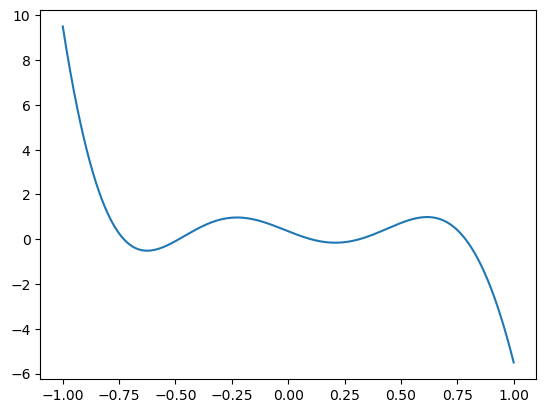

In [50]:
x = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
x_cpu = (x.cpu().detach().numpy())
y = model(x)
normalization_model = torch.trapezoid(y, x, dim=0)
y_cpu = (model(x)/normalization_model).cpu().detach().numpy()
import numpy as np
def analytic_solution(x):
    return np.exp(-0.5 * x**2) / (2 * np.pi)**0.5

plt.plot(x_cpu, y_cpu, label='Sampled')
# plt.plot(x_cpu, analytic_solution(x_cpu), label='Target N(0,1)')